# Introduction

**Definition of each column**
- trending_date: tanggal ketika video trending
- title: judul video
- channel_title: nama channel
- category_id: kategori video dalam label encoding
- publish_time: waktu publish video
- tags: tag yang digunakan pada video
- views: jumlah views video
- likes: jumlah likes video
- dislikes: jumlah dislikes video
- comment_count: jumlah komentar pada video
- comments_disabled: apakah status komentar dinonaktifkan pada video
- ratings_disabled: apakah rating dinonaktifkan pada video
- video_error_or_removed: apakah video error atau sudah dihapus saat ini
- description: deskripsi video
- No_tags: jumlah tags yang digunakan
- desc_len: panjang kata deskripsi video
- len_title: panjang kata judul video
- publish_date: tanggal publish video

**Objective** 
- build a model prediction to predict views youtube

## Libraries

In [52]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def eval_regression(ytest, pred):
    print("MAE: %.2f" % mean_absolute_error(ytest, pred)) # The MAE
    print("RMSE: %.2f" % mean_squared_error(ytest, pred, squared=False)) # The RMSE
    print('R2 score: %.2f' % r2_score(ytest, pred)) # Explained variance score: 1 is perfect prediction

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])
        
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=x.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

## Load Data

In [53]:
df = pd.read_excel('youtube_statistics.xlsx')
df.head(2)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,No_tags,desc_len,len_title,publish_date
0,2017-11-14,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,12:20:39,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...,15,920,81,2017-11-12
1,2017-11-14,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,05:43:56,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",19,2232,58,2017-11-13


## Describe Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36791 entries, 0 to 36790
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trending_date           36791 non-null  object        
 1   title                   36791 non-null  object        
 2   channel_title           36791 non-null  object        
 3   category_id             36791 non-null  int64         
 4   publish_time            36791 non-null  object        
 5   tags                    36791 non-null  object        
 6   views                   36791 non-null  int64         
 7   likes                   36791 non-null  int64         
 8   dislikes                36791 non-null  int64         
 9   comment_count           36791 non-null  int64         
 10  comments_disabled       36791 non-null  bool          
 11  ratings_disabled        36791 non-null  bool          
 12  video_error_or_removed  36791 non-null  bool  

- Total rows : 36791
- Total columns : 18

# Exploratory Data Analysis (EDA)

## Check Null and Missing Values

In [10]:
df.isna().sum()

trending_date              0
title                      0
channel_title              0
category_id                0
publish_time               0
tags                       0
views                      0
likes                      0
dislikes                   0
comment_count              0
comments_disabled          0
ratings_disabled           0
video_error_or_removed     0
description               45
No_tags                    0
desc_len                   0
len_title                  0
publish_date               0
difference_day             0
dtype: int64

In [11]:
data_missing_value = df.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value['percentage'] = round((data_missing_value['missing_value']/len(df))*100,2)
data_missing_value = data_missing_value.sort_values('percentage', ascending=False).reset_index(drop=True)
data_missing_value = data_missing_value[data_missing_value['percentage']>0]
data_missing_value

,feature,missing_value,percentage
0,description,45,0.12


percentage of missing value only 0.12% of total data, so it can be removed.

## Check Duplicate Values

In [12]:
df.duplicated().sum()

4229

there are 4229 duplicated rows, it can be removed too.

## Feature Extraction
*Creating new features from existing features*

In [59]:
df['trending_date'] = df['trending_date'].astype('datetime64[ns]')
df['difference_day'] = df['trending_date'] - df['publish_date']
df['difference_day'] = df['difference_day'].dt.days
df.head()

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,No_tags,desc_len,len_title,publish_date,difference_day
0,2017-11-14,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,12:20:39,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...,15,920,81,2017-11-12,2
1,2017-11-14,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,05:43:56,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",19,2232,58,2017-11-13,1
2,2017-11-14,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,15:48:08,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...,14,482,58,2017-11-12,2
3,2017-11-14,Eruma Saani | Tamil vs English,Eruma Saani,23,07:08:48,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,False,False,False,This video showcases the difference between pe...,20,263,30,2017-11-12,2
4,2017-11-14,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,01:14:16,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...,11,753,88,2017-11-13,1


we want know difference day between trending date and publish date to see how many days need to get a trending video.

## Separated Numerical and Categorical Data

In [60]:
num_dtypes = ['int16','int8', 'int32','int64']
num_df = df.select_dtypes(include=num_dtypes)
numerical = num_df.columns
numerical

Index(['category_id', 'views', 'likes', 'dislikes', 'comment_count', 'No_tags',
       'desc_len', 'len_title', 'difference_day'],
      dtype='object')

In [61]:
cats = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed']

## Graphical Approach

### Univariate Analysis

1. Distribution of Numerical Data

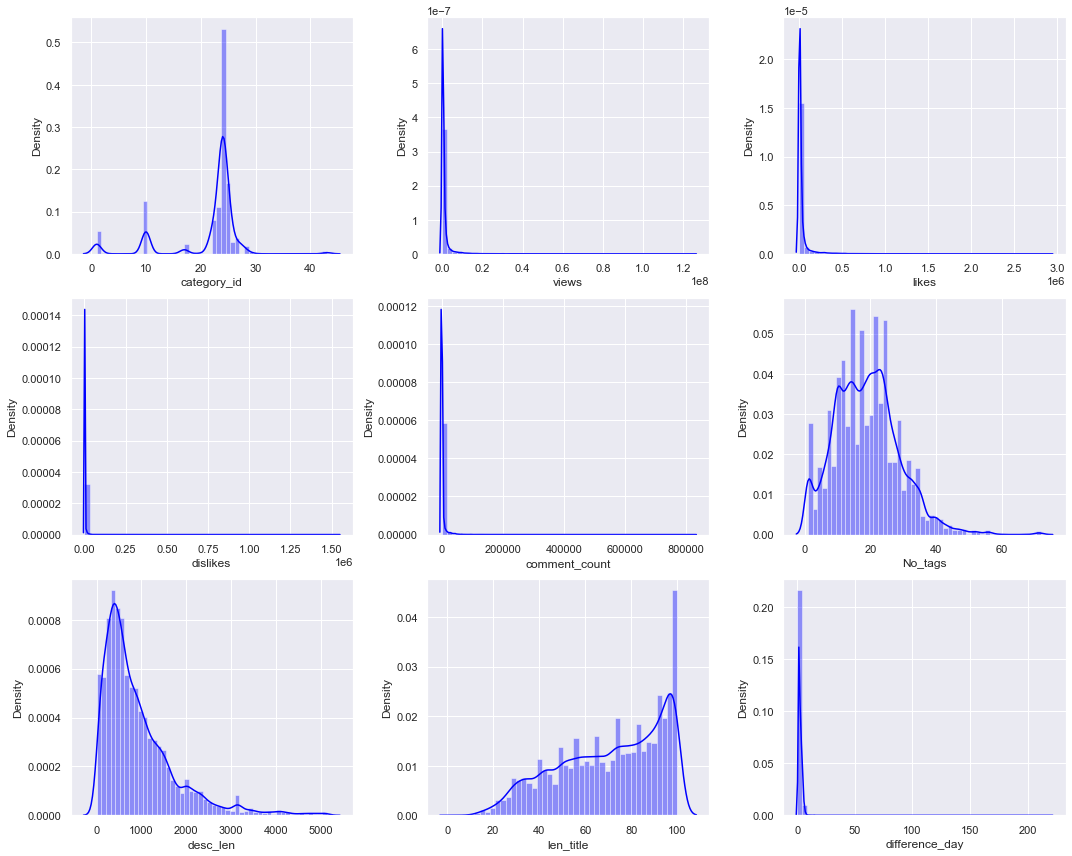

In [62]:
plt.figure(figsize=(15, 12))
for i in range(0, len(numerical)):
    plt.subplot(3, len(numerical)/3, i+1)
    sns.distplot(df[numerical[i]], color='blue')
    plt.tight_layout()

there are many features that have outliers, next we will give treatment for outliers with log transform.

### Multivariate Analysis

<AxesSubplot:>

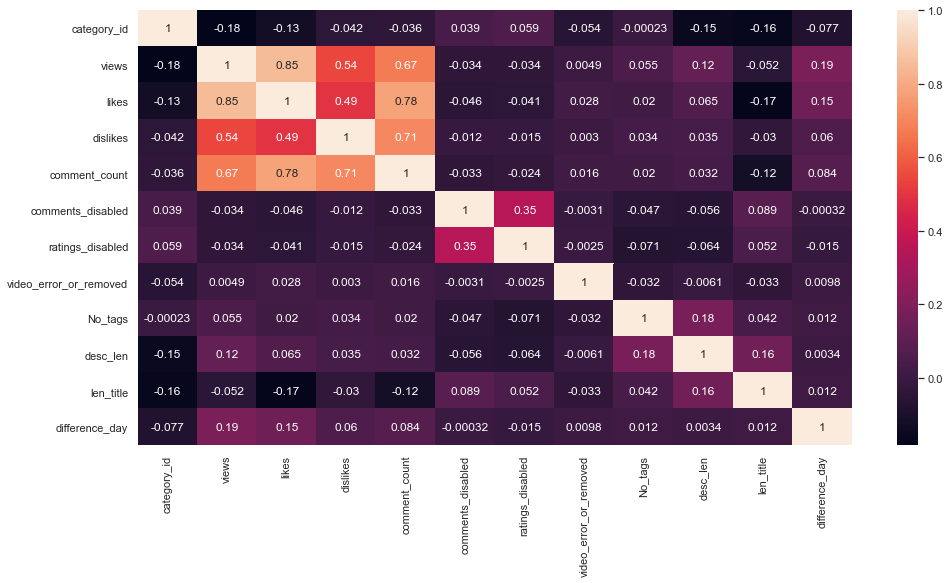

In [63]:
sns.set(rc={'figure.figsize':(16,8)})
sns.heatmap(df.corr(), annot=True)

- views have a strong positive correlation with like, dislike, and comment_count
- dislike has a strong positive correlation with comment_count
- like has a strong positive correlation with comment_count 

# DATA PREPROCESSING

## Fix Missing Values

we removed all missing values

In [64]:
df.dropna(inplace=True)

In [25]:
df.shape

(36746, 19)

## Fix Duplicated Values

we removed all duplicate values

In [65]:
df.drop_duplicates(inplace=True)

In [28]:
df.duplicated().sum()

0

## Treatment outliers with log transform

In [66]:
for var in numerical:
    df[var]= (df[var]+1).apply(np.log)

## FEATURE ENGINEERING

In [67]:
for cat in cats:
    onehots = pd.get_dummies(df[cat], prefix=cat)
    df = df.join(onehots)

By using log transform, we can reduce outliers without deleting data.

In [46]:
df.sample(5)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,...,desc_len,len_title,publish_date,difference_day,comments_disabled_False,comments_disabled_True,ratings_disabled_False,ratings_disabled_True,video_error_or_removed_False,video_error_or_removed_True
21735,2018-03-17,7 AM | ETV Telugu News | 16th March 2018,ETV Andhra Pradesh,25,02:59:53,"ETV|""ETV Telugu""|""ETV NewsVideo""|""National New...",11.520378,6.104793,4.127134,3.555348,...,5.537334,3.713572,2018-03-16,1,1,0,1,0,1,0
5605,2017-12-14,Girlfriend VS Best friends | Part 2 | RealSHIT,RealSHIT,24,14:28:31,"realshit|""real shit""|""realshit new video""|""rea...",12.946056,10.705444,7.033506,7.831220,...,5.910797,3.850148,2017-12-13,1,1,0,1,0,1,0
22224,2018-03-20,Dr. Gulati Hypnotizes Arijit Singh - The Kapil...,SET India,24,06:27:20,"doctor mashoor gulati|""mashoor gulati""|""gulati...",13.657259,8.867427,6.364751,5.752573,...,6.887553,4.077537,2018-03-19,1,1,0,1,0,1,0
18876,2018-02-28,శ్రీదేవి మరణం బోనికపూర్ పై అనుమానంతో విచారణ జర...,Freeticket,24,18:31:08,"FreeTicket|""LatestMovies Viral Videos Breaking...",12.883720,6.428105,5.613128,3.713572,...,5.953243,4.584967,2018-02-26,2,1,0,1,0,1,0
25401,2018-04-07,When Angrezi Babu Meets Desi Mem feat. Sapna C...,Aashqeen,23,09:19:40,"aashqeen|""sapna choudhary""|""funny desi vine""|""...",14.821142,11.965376,9.327412,9.324383,...,6.864848,4.189655,2018-04-03,4,1,0,1,0,1,0


# MODELLING

- In the section below, we will split the train and test data (80:20).
- The data will be standardized using RobustScaler(). RobustScaler is good to use if there are outliers in our data.
- Scaling will be done on the training data first, then the scaling settings of the training data will be used in the next testing data.

In [70]:
df.drop(columns=[ 'trending_date','publish_date','publish_time','tags','title','description','channel_title'], axis=1,inplace=True)
x = df.drop(['views'],axis=1,inplace=False)
y = df['views']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.20, random_state=42)

# Create a train and test dataset
data_train = pd.concat([xtrain, ytrain], axis=1)
data_test  = pd.concat([xtest, ytest], axis=1)

# Standardize the data
scaler    = RobustScaler()
scaler.fit(data_train)
std_train = scaler.transform(data_train)
std_test  = scaler.transform(data_test)

# Turn into data frame
std_train = pd.DataFrame(std_train, columns=data_train.columns)
std_test  = pd.DataFrame(std_test, columns=data_test.columns)

# Re-split the data
xtrain_std = std_train.drop("views", axis=1)
ytrain_std = std_train.views
xtest_std  = std_test.drop("views", axis=1)
ytest_std  = std_test.views

In [71]:
models = {
    "Linear"     : LinearRegression(),
    "Ridge"      : Ridge(),
    "Lasso"      : Lasso(),
    "Elasticnet" : ElasticNet(),
    "DT"         : DecisionTreeRegressor(),
    "RF"         : RandomForestRegressor(),
    "SVR"        : SVR()
}

for model_name, model in models.items():
    model.fit(xtrain_std, ytrain_std)
    y_pred = model.predict(xtest_std)
    print("Evaluate model: {}".format(model_name))
    print(eval_regression(ytest_std, y_pred), "\n")

Evaluate model: Linear
MAE: 0.26
RMSE: 0.33
R2 score: 0.81
None 

Evaluate model: Ridge
MAE: 0.26
RMSE: 0.33
R2 score: 0.81
None 

Evaluate model: Lasso
MAE: 0.59
RMSE: 0.74
R2 score: 0.05
None 

Evaluate model: Elasticnet
MAE: 0.59
RMSE: 0.74
R2 score: 0.05
None 

Evaluate model: DT
MAE: 0.24
RMSE: 0.34
R2 score: 0.80
None 

Evaluate model: RF
MAE: 0.17
RMSE: 0.24
R2 score: 0.90
None 

Evaluate model: SVR
MAE: 0.24
RMSE: 0.31
R2 score: 0.83
None 



From the 7 algorithms tested, the best performance was obtained using random forest, with the lowest RMSE of 0.24 and the lowest R2 score of 0.90. Next we will do hyperparameter tuning

In [72]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

#List Hyperparameters yang akan diuji
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 10)], # Jumlah subtree 
                       criterion = ['mse','mae'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 5)],  # Maximum kedalaman tree
                       n_jobs = [3], # Core untuk parallel computation. -1 untuk menggunakan semua core
                      )

# Init
rf = RandomForestRegressor(random_state=42)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=42, scoring='r2')
rf_tuned.fit(xtrain_std, ytrain_std)

# Predict & Evaluation
y_pred = rf_tuned.predict(xtest_std)#Check performa dari model
eval_regression(ytest_std, y_pred)

MAE: 0.18
RMSE: 0.24
R2 score: 0.90


In [73]:
show_best_hyperparameter(rf_tuned.best_estimator_, hyperparameters)

Best n_estimators: 133
Best criterion: mae
Best max_depth: 85
Best n_jobs: 3


From the model, we can find out which features play an important role in predicting views. The results of feature importance are shown below.

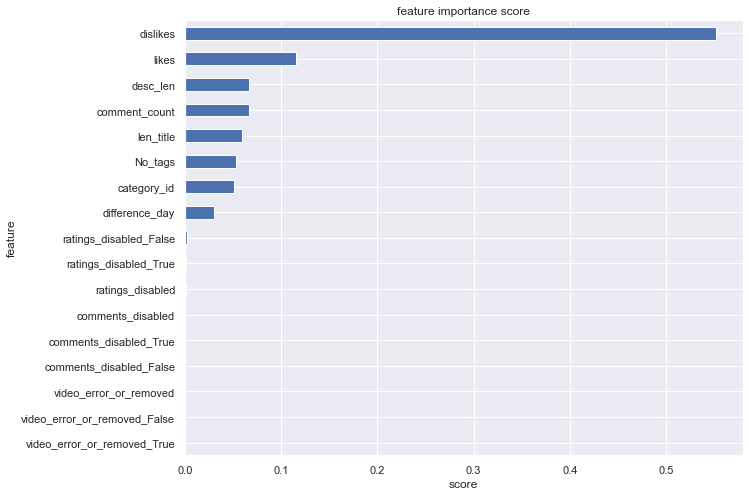

In [74]:
show_feature_importance(rf_tuned.best_estimator_)

Based on the feature importance score above, it can be seen that features dislikes, likes, desc_len are the top importance features that we can focus on to get more views. Other features such as comments_disabled, ratings_disabled, or video_error have very low feature importance scores. 